In [2]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import random

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import torch
import torch.nn as nn

from torchinfo import summary

from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

from timeit import default_timer as timer

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [92]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Age, gender clf/age_gender.csv')
data.shape

(23705, 5)

In [93]:
data['pixels'] = data['pixels'].apply(lambda x: np.array(x.split(), dtype='float32') / 255)

In [94]:
# age_list_bins = np.arange(0, 111, 5) 
# age_list_bins = np.append(age_list_bins, [116])
# age_list_labels = [f"{age_list_bins[i]+1}-{age_list_bins[i+1]}" for i in range(age_list_bins.shape[0]-1)]
# age_labels = {i: age_list_labels[i] for i in range(len(age_list_labels))}

ethnicity_labels = {0:'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Hispanic'}

gender_labels = {0: 'Male', 1: 'Female'}

In [101]:
# data['age'] = pd.cut(data['age'], age_list_bins, labels=np.arange(len(age_list_bins)-1)).astype('int')

# Distributions

In [7]:
px.histogram(data, x='age', color='gender') #category_orders={'age': data['age'].cat.categories}

In [ ]:
px.histogram(data, x='ethnicity', color='gender')

# Sample images

In [ ]:
rand_list = [random.randint(0, data.shape[0]-1) for i in range(20)]

In [ ]:
plt.figure(figsize=(20, 16))
for i in range(len(rand_list)):
    plt.subplot(4, 5, i+1)
    row = data.iloc[rand_list[i]]
    plt.imshow(row['pixels'].reshape(48, 48), cmap='gray')
    plt.title(f'Age: {row.age}, Ethnicity: {row.ethnicity}, Gender: {row.gender}')
    plt.axis('off')

# Data preparation

In [95]:
train_set, val_set = train_test_split(data, train_size=0.9, random_state=0, stratify=data['ethnicity'], shuffle=True)

In [96]:
class MyDataset(Dataset):
    def __init__(self, target_label, image):
        self.target_label = np.array(target_label)
        self.image = np.array(image)
        
        self.transform = transforms.Compose([
            # transforms.Resize((48, 48)),
            # transforms.ToPILImage(),
            # transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.5], std=[0.5]),
        ])
        
    def __len__(self):
        return len(self.image)
        
    def __getitem__(self, index):
        target_label = self.target_label[index]
        image = self.image[index].reshape(48, 48, 1)
        image = self.transform(image)
        
        return image, target_label
    
train_data_age = MyDataset(train_set.age, train_set.pixels)
val_data_age = MyDataset(val_set.age, val_set.pixels)

train_data_ethnicity = MyDataset(train_set.ethnicity, train_set.pixels)
val_data_ethnicity = MyDataset(val_set.ethnicity, val_set.pixels)

train_data_gender = MyDataset(train_set.gender, train_set.pixels)
val_data_gender = MyDataset(val_set.gender, val_set.pixels)

In [97]:
batch_size=128

train_loader_age = DataLoader(train_data_age, batch_size=batch_size, shuffle=True)
val_loader_age = DataLoader(val_data_age, batch_size=batch_size, shuffle=False)

train_loader_ethnicity = DataLoader(train_data_ethnicity, batch_size=batch_size, shuffle=True)
val_loader_ethnicity = DataLoader(val_data_ethnicity, batch_size=batch_size, shuffle=False)

train_loader_gender = DataLoader(train_data_gender, batch_size=batch_size, shuffle=True)
val_loader_gender = DataLoader(val_data_gender, batch_size=batch_size, shuffle=False)

# Model

In [98]:
age_features = data['age'].nunique()
ethnicity_features = data['ethnicity'].nunique()
gender_features = data['gender'].nunique()

In [99]:
class MultilabelCNN(nn.Module):
    def __init__(self, target_features):
        super().__init__()
        
        self.CNNModel = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1), #24
            # nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1), #12
            # nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1), #6
            nn.LeakyReLU(),
            # # nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1), #3
            # nn.Dropout(0.1),
            nn.AdaptiveAvgPool2d((1,1)), #flatten
            nn.Flatten()
            # nn.LeakyReLU()
        )

        self.DNNModel = nn.Sequential(
            nn.Linear(256, 128),
            # # nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            # nn.Dropout(0.1),
            nn.LeakyReLU(),
            # nn.Dropout(0.4), 
            nn.Linear(64, 32),
            # nn.Dropout(0.1), 
            nn.LeakyReLU())
        
        if target_features > 20:
          self.target_layer = nn.Linear(32, 1)
        else:
          self.target_layer = nn.Linear(32, target_features)
        
    def forward(self, x):
        output = self.CNNModel(x).squeeze()
        output = self.DNNModel(output)

        pred = self.target_layer(output)
        
        return pred

In [100]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_age = MultilabelCNN(age_features).to(device)
model_ethnicity = MultilabelCNN(ethnicity_features).to(device)
model_gender = MultilabelCNN(gender_features).to(device)



# optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-5)

loss_ethnicity_gender = nn.CrossEntropyLoss()
loss_age = nn.MSELoss()

In [ ]:
summary(model_age, input_size=(1, 48, 48))

# Train loop

In [101]:
def train_step(model, 
               dataloader,
               loss_function,
               optimizer,
               device):
    
    model.train()
    train_loss, train_acc = 0, 0
    
    for batch, (image, y) in enumerate(dataloader):        

        image, y = image.to(device), y.to(device)

        y_pred = model(image)
        loss = loss_function(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y)
        
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    return train_loss, train_acc

In [102]:
def val_step(model, 
             dataloader,
             loss_function, 
             device):
    
    model.eval()
    val_loss, val_acc = 0, 0
    y_preds = []
    
    with torch.inference_mode():
        for batch, (image, y) in enumerate(dataloader):
            image, y = image.to(device), y.to(device)

            y_pred = model(image)

            loss = loss_function(y_pred, y)
            val_loss += loss.item()

            y_pred_class = torch.argmax(y_pred, dim=1)
            val_acc += (y_pred_class == y).sum().item() / len(y)
            
            y_preds.append(y_pred_class.cpu())
            
    val_loss /= len(dataloader)
    val_acc /= len(dataloader)
    
    y_pred_tensor = torch.cat(y_preds)
    return val_loss, val_acc, y_pred_tensor

In [103]:
def train(model, 
          train_dataloader,
          val_dataloader,
          loss_function,
          optimizer,
          epochs, 
          device):
    
    results = {'train_loss': [], 
               'train_acc': [], 
               'val_loss': [], 
               'val_acc': []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_function=loss_function,
                                           optimizer=optimizer,
                                           device=device)
        
        val_loss, val_acc, y_preds = val_step(model=model, 
                                              dataloader=val_dataloader,
                                              loss_function=loss_function,
                                              device=device)
        
        print(f'Epoch: {epoch+1} , Train loss: {train_loss:.3f}, Validation loss: {val_loss:.3f}')
        print(f'Train accuracy: {train_acc:.3f}, Validation accuracy: {val_acc:.3f}')
        print()
        
        results['train_loss'].append(train_loss)
        results['val_loss'].append(val_loss)
        results['train_acc'].append(train_acc)
        results['val_acc'].append(val_acc)
        
    return results, y_preds

# Running model

## Ethnicity model

In [122]:
torch.cuda.manual_seed(0)
torch.manual_seed(0)

epochs = 50

loss_function = loss_ethnicity_gender

model_ethnicity = MultilabelCNN(ethnicity_features).to(device)

optimizer = torch.optim.Adam(params=model_ethnicity.parameters(), lr=3e-4, weight_decay=1e-5)

start_timer = timer()

model_results, preds = train(model=model_ethnicity, 
                             train_dataloader=train_loader_ethnicity,
                             val_dataloader=val_loader_ethnicity,
                             loss_function=loss_function,
                             optimizer=optimizer,
                             epochs=epochs,
                             device=device)

end_timer = timer()

print(f'Total learning time: {(end_timer - start_timer):.3f}')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 , Train loss: 1.447, Validation loss: 1.372
Train accuracy: 0.421, Validation accuracy: 0.472

Epoch: 2 , Train loss: 1.345, Validation loss: 1.304
Train accuracy: 0.477, Validation accuracy: 0.482

Epoch: 3 , Train loss: 1.280, Validation loss: 1.241
Train accuracy: 0.495, Validation accuracy: 0.505

Epoch: 4 , Train loss: 1.232, Validation loss: 1.205
Train accuracy: 0.514, Validation accuracy: 0.517

Epoch: 5 , Train loss: 1.196, Validation loss: 1.158
Train accuracy: 0.534, Validation accuracy: 0.545

Epoch: 6 , Train loss: 1.162, Validation loss: 1.120
Train accuracy: 0.550, Validation accuracy: 0.565

Epoch: 7 , Train loss: 1.100, Validation loss: 1.071
Train accuracy: 0.580, Validation accuracy: 0.593

Epoch: 8 , Train loss: 1.010, Validation loss: 0.943
Train accuracy: 0.626, Validation accuracy: 0.662

Epoch: 9 , Train loss: 0.938, Validation loss: 0.910
Train accuracy: 0.660, Validation accuracy: 0.677

Epoch: 10 , Train loss: 0.887, Validation loss: 0.857
Train accu

### Saving model

In [125]:
PATH = '/content/drive/MyDrive/Colab Notebooks/Age, gender clf/'

torch.save(model_ethnicity, PATH+'model ethnicity.pt')

### Loss & accuracy

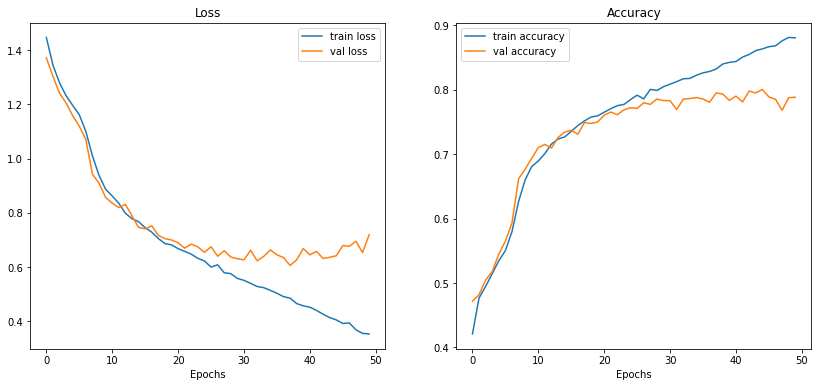

In [126]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(np.arange(len(model_results['train_loss'])), model_results['train_loss'], label='train loss')
plt.plot(np.arange(len(model_results['val_loss'])), model_results['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(122)
plt.plot(np.arange(len(model_results['train_acc'])), model_results['train_acc'], label='train accuracy')
plt.plot(np.arange(len(model_results['val_acc'])), model_results['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

In [65]:
# age_preds = preds[::3]
# ethnicity_preds = preds[1::3]
# gender_preds = preds[2::3]

# age_preds_np = np.array(list(map(lambda x: x.cpu().item(), age_preds)))
# ethnicity_preds_np = np.array(list(map(lambda x: x.cpu().item(), ethnicity_preds)))
# gender_preds_np = np.array(list(map(lambda x: x.cpu().item(), gender_preds)))

## Gender model

In [127]:
torch.cuda.manual_seed(0)
torch.manual_seed(0)

epochs = 50

loss_function = loss_ethnicity_gender

model_gender = MultilabelCNN(gender_features).to(device)

optimizer = torch.optim.Adam(params=model_gender.parameters(), lr=3e-4, weight_decay=1e-5)

start_timer = timer()

model_results, preds = train(model=model_gender, 
                             train_dataloader=train_loader_gender,
                             val_dataloader=val_loader_gender,
                             loss_function=loss_function,
                             optimizer=optimizer,
                             epochs=epochs,
                             device=device)

end_timer = timer()

print(f'Total learning time: {(end_timer - start_timer):.3f}')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 , Train loss: 0.669, Validation loss: 0.619
Train accuracy: 0.580, Validation accuracy: 0.667

Epoch: 2 , Train loss: 0.593, Validation loss: 0.549
Train accuracy: 0.680, Validation accuracy: 0.726

Epoch: 3 , Train loss: 0.502, Validation loss: 0.439
Train accuracy: 0.757, Validation accuracy: 0.799

Epoch: 4 , Train loss: 0.426, Validation loss: 0.405
Train accuracy: 0.808, Validation accuracy: 0.826

Epoch: 5 , Train loss: 0.394, Validation loss: 0.382
Train accuracy: 0.823, Validation accuracy: 0.828

Epoch: 6 , Train loss: 0.367, Validation loss: 0.353
Train accuracy: 0.840, Validation accuracy: 0.848

Epoch: 7 , Train loss: 0.344, Validation loss: 0.352
Train accuracy: 0.852, Validation accuracy: 0.840

Epoch: 8 , Train loss: 0.323, Validation loss: 0.319
Train accuracy: 0.863, Validation accuracy: 0.863

Epoch: 9 , Train loss: 0.306, Validation loss: 0.307
Train accuracy: 0.870, Validation accuracy: 0.862

Epoch: 10 , Train loss: 0.288, Validation loss: 0.310
Train accu

### Saving model

In [128]:
PATH = '/content/drive/MyDrive/Colab Notebooks/Age, gender clf/'

torch.save(model_gender, PATH+'model gender.pt')

### Loss & accuracy

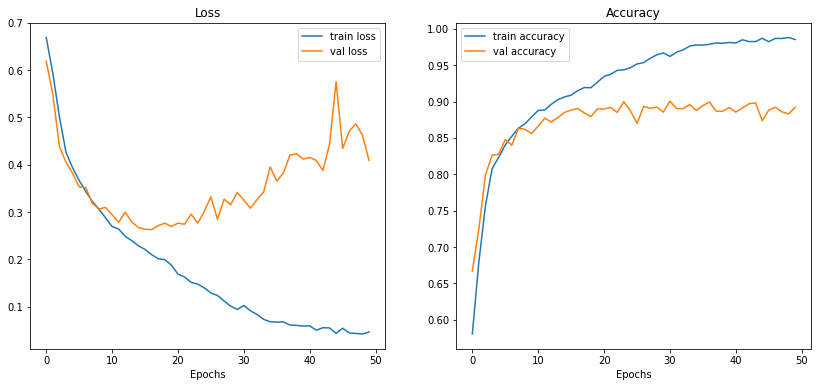

In [130]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(np.arange(len(model_results['train_loss'])), model_results['train_loss'], label='train loss')
plt.plot(np.arange(len(model_results['val_loss'])), model_results['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(122)
plt.plot(np.arange(len(model_results['train_acc'])), model_results['train_acc'], label='train accuracy')
plt.plot(np.arange(len(model_results['val_acc'])), model_results['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

## Age model

In [110]:
def train_step_age(model, 
                   dataloader,
                   loss_function,
                   optimizer,
                   device):
    
    model.train()
    train_loss = 0
    for batch, (image, y) in enumerate(dataloader):        

        image, y = image.to(device), y.view(-1, 1).to(torch.float32).to(device)

        y_pred = model(image)
        loss = loss_function(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
    train_loss /= len(dataloader)    
    return train_loss

In [111]:
def val_step_age(model, 
                 dataloader,
                 loss_function, 
                 device):
    
    model.eval()
    y_preds = []
    val_loss = 0
    with torch.inference_mode():
        for batch, (image, y) in enumerate(dataloader):
            image, y = image.to(device), y.view(-1, 1).to(torch.float32).to(device)

            y_pred = model(image)

            loss = loss_function(y_pred, y)
            val_loss += loss.item()
            y_preds.append(y_pred)
            
    val_loss /= len(dataloader)
    
    return val_loss, y_preds

In [112]:
def train_age(model, 
              train_dataloader,
              val_dataloader,
              loss_function,
              optimizer,
              epochs, 
              device):
    
    results = {'train_loss': [], 
               'val_loss': []}
    
    for epoch in tqdm(range(epochs)):
        train_loss = train_step_age(model=model,
                                    dataloader=train_dataloader,
                                    loss_function=loss_function,
                                    optimizer=optimizer,
                                    device=device)
        
        val_loss, y_preds = val_step_age(model=model, 
                                         dataloader=val_dataloader,
                                         loss_function=loss_function,
                                         device=device)
        
        print(f'Epoch: {epoch+1} , Train loss: {train_loss:.3f}, Validation loss: {val_loss:.3f}')
        print()
        
        results['train_loss'].append(train_loss)
        results['val_loss'].append(val_loss)
        
    return results, y_preds

In [113]:
torch.cuda.manual_seed(0)
torch.manual_seed(0)

epochs = 200

loss_function = loss_age

optimizer = torch.optim.Adam(params=model_age.parameters(), lr=3e-4, weight_decay=1e-5)

start_timer = timer()

model_results, preds = train_age(model=model_age, 
                                 train_dataloader=train_loader_age,
                                 val_dataloader=val_loader_age,
                                 loss_function=loss_function,
                                 optimizer=optimizer,
                                 epochs=epochs,
                                 device=device)

end_timer = timer()

print(f'Total learning time: {(end_timer - start_timer):.3f}')

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 , Train loss: 596.630, Validation loss: 400.509

Epoch: 2 , Train loss: 397.064, Validation loss: 365.976

Epoch: 3 , Train loss: 381.681, Validation loss: 356.902

Epoch: 4 , Train loss: 370.980, Validation loss: 349.492

Epoch: 5 , Train loss: 354.163, Validation loss: 328.663

Epoch: 6 , Train loss: 339.297, Validation loss: 322.648

Epoch: 7 , Train loss: 313.880, Validation loss: 302.869

Epoch: 8 , Train loss: 284.254, Validation loss: 266.338

Epoch: 9 , Train loss: 258.834, Validation loss: 253.083

Epoch: 10 , Train loss: 239.624, Validation loss: 213.159

Epoch: 11 , Train loss: 217.178, Validation loss: 207.002

Epoch: 12 , Train loss: 199.115, Validation loss: 256.270

Epoch: 13 , Train loss: 191.537, Validation loss: 173.729

Epoch: 14 , Train loss: 177.283, Validation loss: 174.114

Epoch: 15 , Train loss: 169.005, Validation loss: 160.645

Epoch: 16 , Train loss: 168.267, Validation loss: 161.820

Epoch: 17 , Train loss: 163.057, Validation loss: 165.037

Epoch:

### Saving model

In [114]:
PATH = '/content/drive/MyDrive/Colab Notebooks/Age, gender clf/'

torch.save(model_age, PATH+'model age.pt')

### Loss

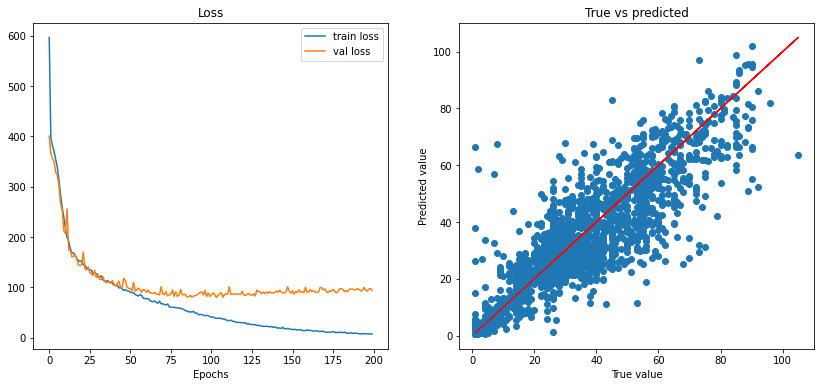

In [115]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(np.arange(len(model_results['train_loss'])), model_results['train_loss'], label='train loss')
plt.plot(np.arange(len(model_results['val_loss'])), model_results['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(122)
# plt.plot(np.arange(len(model_results['train_acc'])), model_results['train_acc'], label='train accuracy')
# plt.plot(np.arange(len(model_results['val_acc'])), model_results['val_acc'], label='val accuracy')
plt.scatter(val_data_age.target_label, torch.cat(preds).to('cpu').numpy().reshape(-1))
plt.plot(val_data_age.target_label, val_data_age.target_label, color='red')
plt.title('True vs predicted')
plt.xlabel('True value')
plt.ylabel('Predicted value')
# plt.legend()

plt.show()

# Experimenting with other images

In [131]:
from PIL import Image

In [156]:
def predict_aeg(path, model_age, model_ethnicity, model_gender):
    face = Image.open(path)

    height = face.height
    width = face.width
    ratio = height / width

    transform = transforms.Compose([
              transforms.Grayscale(),
              transforms.Resize((48, 48)),
              transforms.ToTensor(),
              # transforms.Normalize(mean=[0.5], std=[0.5]),
          ])
    
    transformed_face = transform(face)

    pred_age = model_age(transformed_face.to(device))
    pred_ethnicity = model_ethnicity(transformed_face.to(device))
    pred_gender = model_gender(transformed_face.to(device))

    pred_age = int(torch.round(pred_age).item())
    pred_ethnicity = torch.argmax(pred_ethnicity).item()
    pred_gender = torch.argmax(pred_gender).item()

    min_age = max(0, pred_age-2)


    print(f'Age: {min_age}-{pred_age+2}\nEthnicity: {ethnicity_labels[pred_ethnicity]}\nGender: {gender_labels[pred_gender]}')
    print()
    display(transforms.Resize((int(400*ratio), 400))(face))

Age: 9-13
Ethnicity: Asian
Gender: Male



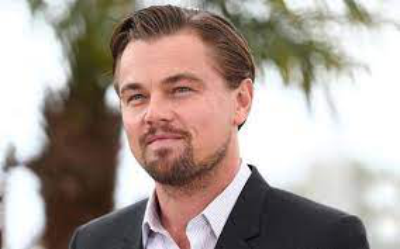

In [133]:
predict_aeg('лул.jpeg', model_age, model_ethnicity, model_gender)

In [150]:
import cv2
import os

Exception Occured [Errno 17] File exists: '/content'
Age: 40-44
Ethnicity: White
Gender: Female



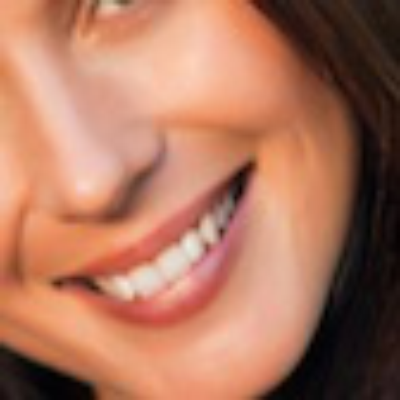

Age: 5-9
Ethnicity: White
Gender: Female



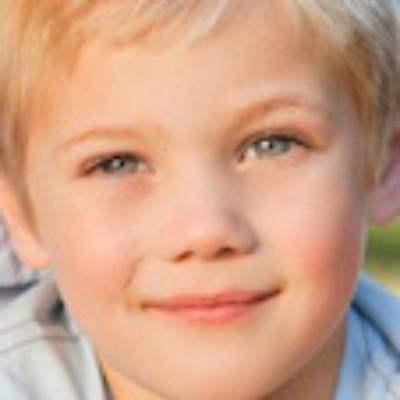

Age: 30-34
Ethnicity: White
Gender: Male



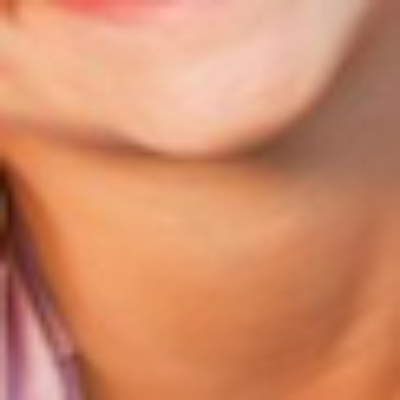

In [160]:
img = cv2.imread('497sdt9f.jpg') #Path of an image
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = faceCascade.detectMultiScale(img,1.1,4)

directory = os.getcwd()+r''

try:
    os.mkdir(directory)
except FileExistsError as fee:
    print('Exception Occured',fee)
os.chdir(directory)
i=1
for (x, y, w, h) in faces:
    FaceImg = img[y:y+h,x:x+w]
    # To save an image on disk
    filename = 'Face'+str(i)+'.jpg'
    cv2.imwrite(filename,FaceImg)
    i+=1
    predict_aeg(filename, model_age, model_ethnicity, model_gender)